## Basics

In [1]:
def get_results_for_p(p,all_results):
    # Create the key as a tuple
    key = (p.num_z,p.num_v,p.num_n,p.n_bar,p.num_q,p.q_0,p.prod_q,p.hire_c,p.prod_alpha,p.dt)
    # Check if the key exists in the saved results
    if key in all_results:
        return all_results[key]
    else:
        print(f"No results found for p = {key}")
        return None

from primitives import Parameters
p = Parameters()
import pickle
import matplotlib.pyplot as plt
import numpy as np
from plots import Plots
import cProfile
import pstats

plts=Plots(p)
cc_J,cc_W,cc_Wstar,cc_Jpi,cc_pc,mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n1,mwc_s_J,mwc_s_W,mwc_s_Wstar,mwc_s_sep,mwc_sd_J,mwc_sd_W,mwc_sd_Wstar,mwc_sd_sep=None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None

In [2]:
# Load the temp objects
try:
    with open('my_objects.pkl', 'rb') as file:
        objects = pickle.load(file)
except FileNotFoundError:
    # If the file doesn't exist, start with an empty dictionary
    objects = {}

# Load the permanent results, for sep, across different parametrizations
with open("results_hmq_sep.pkl", "rb") as file:
    all_results = pickle.load(file)

In [3]:
from ContinuousContract import ContinuousContract
cc=ContinuousContract(p)
(cc_J,cc_W,cc_Wstar,cc_Jpi,cc_pc)=cc.J(0)

In [4]:
from Multiworker_Contract_hire_hmq import MultiworkerContract
K=2 #number of tenure levels
mwc_hmq=MultiworkerContract(p,cc.js)

In [8]:
# HMQ Separations

results = get_results_for_p(p,all_results)
if results is None:
    mwc_hmq_sd_J = objects['mwc_hmq_sd_J']
    mwc_hmq_sd_W = objects['mwc_hmq_sd_W']
else:
    mwc_hmq_sd_J = results['Ji']
    mwc_hmq_sd_W = results['W1i']

(mwc_hmq_sd_J,mwc_hmq_sd_W,mwc_hmq_sd_Wstar,mwc_hmq_sd_sep,mwc_hmq_sd_n0,mwc_hmq_sd_n1)=mwc_hmq.J_sep_dir(mwc_hmq_sd_J,mwc_hmq_sd_W)

objects['mwc_hmq_sd_J'] = mwc_hmq_sd_J
objects['mwc_hmq_sd_W'] = mwc_hmq_sd_W

with open('my_objects.pkl', 'wb') as file:
    pickle.dump(objects, file)

No results found for p = (1, 100, 5, 4, 6, 0.5, 0.95, 90.0, 1.0, 0.25)
Ji shape (1, 5, 5, 100, 6)
W1i shape (1, 5, 5, 100, 6, 2)
q_star [0.5 0.5 0.5 0.5 0.5 0.5]
Errors: 9.53735038394151e-08 5.734560974532501e-22 1


c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\Multiworker_Contract_hire_hmq.py:1239: RuntimeWarning: invalid value encountered in divide
  J_fut_deriv_n = (J_n1[iz,in0,in1,iv,iq,s,n1_s_ceil]-J_n1[iz,in0,in1,iv,iq,s,n1_s_floor] ) / (N_grid1[n1_s_ceil]-N_grid1[n1_s_floor])


q_s borders 0.5 1.0
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
check, arrived to calculating foc_sep
check, calculated foc_sep
sep borders 0.0 0.0
q_star [0.5 0.5 0.5 0.5 0.5 0.5]
EJinv 21.236056040690706
EJderiv 21.44423802173387
EJinv diff 1j 2s: 0.014057179084994504
EJinv diff 1 sen: 2.7632983263206485e-09
EJinv diff 2 sen: 2.76358812978349e-09
q_s borders 0.5 1.0
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
check, arrived to calculating foc_sep
check, calculated foc_sep
sep borders 0.0 0.0
q_star [0.5 0.5 0.5 0.5 0.5 0.5]
n0_star borders 0.0 0.0
sep borders 0.0 0.0
EJinv 21.23608995497861
EJderiv 21.44423802168229
EJinv diff 1j 2s: 0.014055041227354998
EJinv diff 1 sen: 2.7634839249731275e-09
EJinv diff 2 sen: 2.7634481364963057e-09
q_s borders 0.5 1.0
(array([], dtype=int64), array(

In [6]:
mwc_hmq.Q_grid[5]

1.0

In [ ]:
# HMQ
mwc_hmq_J = objects['mwc_hmq_J']
mwc_hmq_W = objects['mwc_hmq_W']

profiler = cProfile.Profile()
profiler.enable()
#(mwc_hmq_J,mwc_hmq_W,mwc_hmq_Wstar,mwc_hmq_pc,mwc_hmq_n0,mwc_hmq_n1)=mwc_hmq.J()
(mwc_hmq_J,mwc_hmq_W,mwc_hmq_Wstar,mwc_hmq_pc,mwc_hmq_n0,mwc_hmq_n1,Jd_n0,Jd_check)=mwc_hmq.J()
profiler.disable()

# Print profiling results
stats = pstats.Stats(profiler).sort_stats(pstats.SortKey.TIME)
stats.print_stats()
#still to do: introduce HMQ into the separations.
#also gotta check that his actually works.
#also this seems slow af
objects['mwc_hmq_J'] = mwc_hmq_J
objects['mwc_hmq_W'] = mwc_hmq_W

with open('my_objects.pkl', 'wb') as file:
    pickle.dump(objects, file)

In [ ]:
# Retrieve the objects
#mwch_J = objects['mwch_J']
#mwch_W = objects['mwch_W']

from Multiworker_Contract_hire import MultiworkerContract
K=2 #number of tenure levels
mwch=MultiworkerContract(p,cc.js)
(mwch_J,mwch_W,mwch_Wstar,mwch_pc,mwch_n0,mwch_n1)=mwch.J()
#(mwch_J,mwch_W,mwch_Wstar,mwch_pc,mwch_n0,mwch_n1)=mwch.J(mwch_J,mwch_W)

objects['mwch_J'] = mwch_J
objects['mwch_W'] = mwch_W

with open('my_objects.pkl', 'wb') as file:
    pickle.dump(objects, file)

In [ ]:
(mwch_s_J,mwch_s_W,mwch_s_Wstar,mwch_s_sep,mwch_s_n0,mwch_s_n1)=mwch.J_sep(mwch_J,mwch_W)

In [ ]:
(mwch_sd_J,mwch_sd_W,mwch_sd_Wstar,mwch_sd_sep,mwch_sd_n0,mwch_sd_n1)=mwch.J_sep_dir(mwch_J,mwch_W)

In [6]:
from Multiworker_Contract_all import MultiworkerContract
K=2 #number of tenure levels
mwc=MultiworkerContract(p,cc.js)
(mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n0,mwc_n1)=mwc.J()


Ji shape (1, 5, 5, 100)
W1i shape (1, 5, 5, 100, 2)
n0_star borders 0.0 0.0
Errors: 0.16341430140551638 2.676345181240897 1.6827731562978465 3.2479757098313526 1
Errors: 0.0 2.676345181240897 1.6827731562978465 3.2479757098313526 1
n0_star borders 0.0 0.0
EJinv 190.12936834985388
EJderiv 191.3852663882363
EJinv diff 1j 2s: 0.11444870338153229
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 4.0
EJinv 197.97794249660134
EJderiv 187.6974055219416
EJinv diff 1j 2s: 0.06753570117959587
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 4.0
EJinv 200.56789904940098
EJderiv 184.09000835374087
EJinv diff 1j 2s: 0.08208829700904398
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 4.0
EJinv 200.0874382529701
EJderiv 180.56131930511378
EJinv diff 1j 2s: 0.10859632037070745
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan


c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\Multiworker_Contract_all.py:350: RuntimeWarning: invalid value encountered in divide
  print("EJinv diff 1 sen:", np.mean(np.abs((EJinv[:,0,1,:]/pc_star[:,0,1,:] - EJderiv[:,0,1,:]) / EJderiv[:,0,1,:])))
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\Multiworker_Contract_all.py:351: RuntimeWarning: invalid value encountered in divide
  print("EJinv diff 2 sen:", np.mean(np.abs((EJinv[:,0,s,:]/pc_star[:,0,s,:] - EJderiv[:,0,s,:]) / EJderiv[:,0,s,:])))


n0_star borders 0.0 4.0
EJinv 197.84255563002674
EJderiv 177.10962106813002
EJinv diff 1j 2s: 0.12135566268369491
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 4.0
EJinv 194.6109756037303
EJderiv 173.73323384914636
EJinv diff 1j 2s: 0.125884723668034
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 4.0
EJinv 190.8543133540632
EJderiv 170.4305144554017
EJinv diff 1j 2s: 0.12553939338086736
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 4.0
EJinv 186.84521302641755
EJderiv 167.1998555391057
EJinv diff 1j 2s: 0.12235582807806326
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 4.0
EJinv 182.74350321324124
EJderiv 164.03968487453452
EJinv diff 1j 2s: 0.11756555343178339
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 4.0
Errors: 0.07541156039317848 0.00023638047195832313 2.54196184351674 0.0016998013501674063 1
EJinv 178.64178752426167
EJderiv 160.94846448589803
EJinv diff 1j 2s: 0.11191014785179641
EJinv diff

c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\Multiworker_Contract_all.py:350: RuntimeWarning: divide by zero encountered in divide
  print("EJinv diff 1 sen:", np.mean(np.abs((EJinv[:,0,1,:]/pc_star[:,0,1,:] - EJderiv[:,0,1,:]) / EJderiv[:,0,1,:])))


EJinv diff 1 sen: inf
EJinv diff 2 sen: 0.07000811293610146
n0_star borders 0.0 0.0
EJinv 42.94275523867414
EJderiv 43.611189831064
EJinv diff 1j 2s: 0.07530138546808511
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 0.0
EJinv 42.50220077032974
EJderiv 43.14752146516401
EJinv diff 1j 2s: 0.07422427853290553
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 0.0
EJinv 42.071969786100524
EJderiv 42.69396987999199
EJinv diff 1j 2s: 0.07312984796033827
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 0.0
EJinv 41.651806023380786
EJderiv 42.250314349587406
EJinv diff 1j 2s: 0.07201898747638366
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 0.0
EJinv 41.241460163081506
EJderiv 41.81633896280217
EJinv diff 1j 2s: 0.07089257871645632
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 0.0
Errors: 0.008631039597007662 0.000100064795677454 32.5846757629358 2.4884565684140465e-05 1
Errors: 0.0 0.000100064795677454 32.584675

c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\Multiworker_Contract_all.py:351: RuntimeWarning: divide by zero encountered in divide
  print("EJinv diff 2 sen:", np.mean(np.abs((EJinv[:,0,s,:]/pc_star[:,0,s,:] - EJderiv[:,0,s,:]) / EJderiv[:,0,s,:])))


n0_star borders 0.0 0.0
EJinv 33.12147457763675
EJderiv 33.084836794910345
EJinv diff 1j 2s: 0.03811558713446029
EJinv diff 1 sen: 0.04318782846994754
EJinv diff 2 sen: inf
n0_star borders 0.0 0.0
EJinv 32.90742250459159
EJderiv 32.85084560085579
EJinv diff 1j 2s: 0.03693991896606221
EJinv diff 1 sen: 0.0425990664811791
EJinv diff 2 sen: inf
n0_star borders 0.0 0.0
EJinv 32.69821935927312
EJderiv 32.62195996896823
EJinv diff 1j 2s: 0.03577001188174775
EJinv diff 1 sen: 0.042015001214242426
EJinv diff 2 sen: nan
n0_star borders 0.0 0.0
EJinv 32.49375156221843
EJderiv 32.398068499215995
EJinv diff 1j 2s: 0.034617976576614466
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 0.0
Errors: 0.0009183300674313714 4.431277612693964e-05 47.68825019462829 1.669181498918655e-06 1
EJinv 32.29390835108815
EJderiv 32.17906222317308
EJinv diff 1j 2s: 0.033474764555027806
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 0.0
EJinv 32.098581705803284
EJderiv 31.96483454931063

# Plots

In [ ]:
#Okay, so we've got some inconsistencies:
#CRS lower than everyone
#HMQ and and basic MWC (without allowing for hiring) are the same
#MWC with hiring is higher than the others (despite hiring being too costly)
#wtf?
#Trying mwch without a guess now

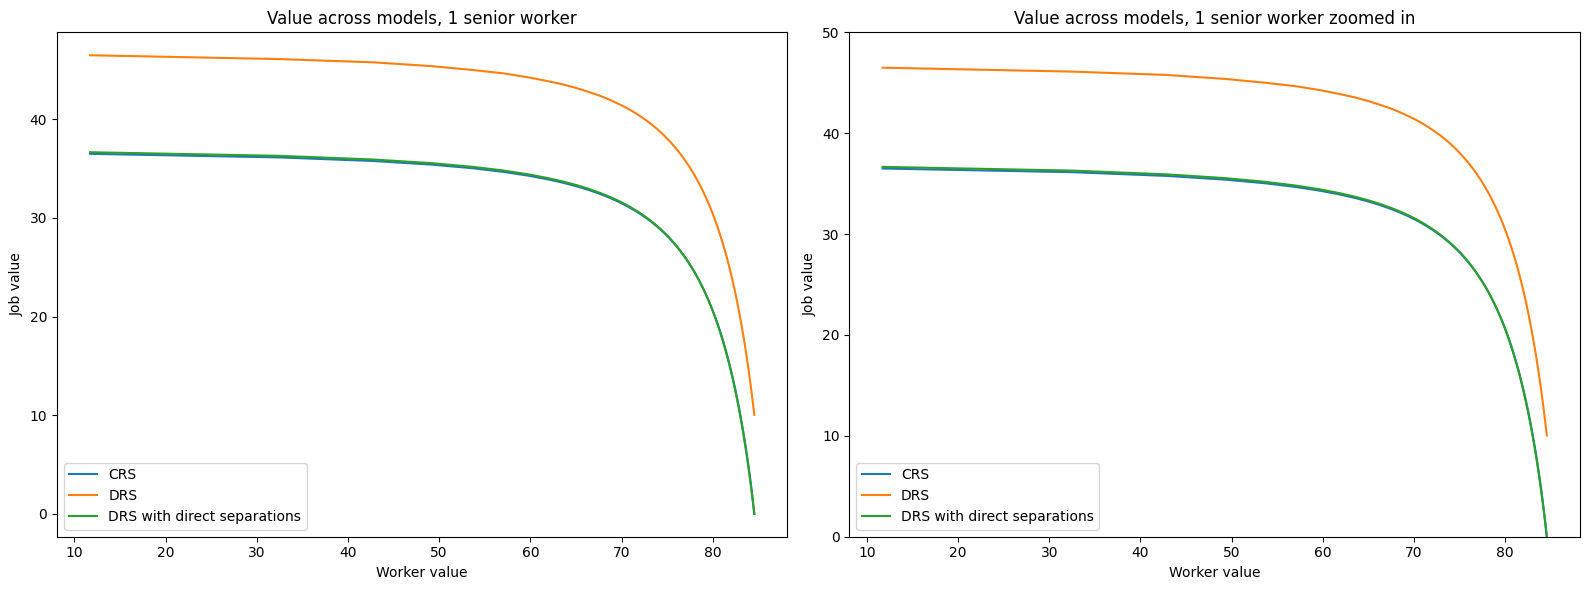

In [9]:
plts.CRSvsDRSvalue(cc_W,cc_J,mwc_hmq_sd_W[...,5,:],mwc_hmq_sd_J[...,5]/mwc_hmq.N_grid1[1],None,None,mwc_W,mwc_J,0)

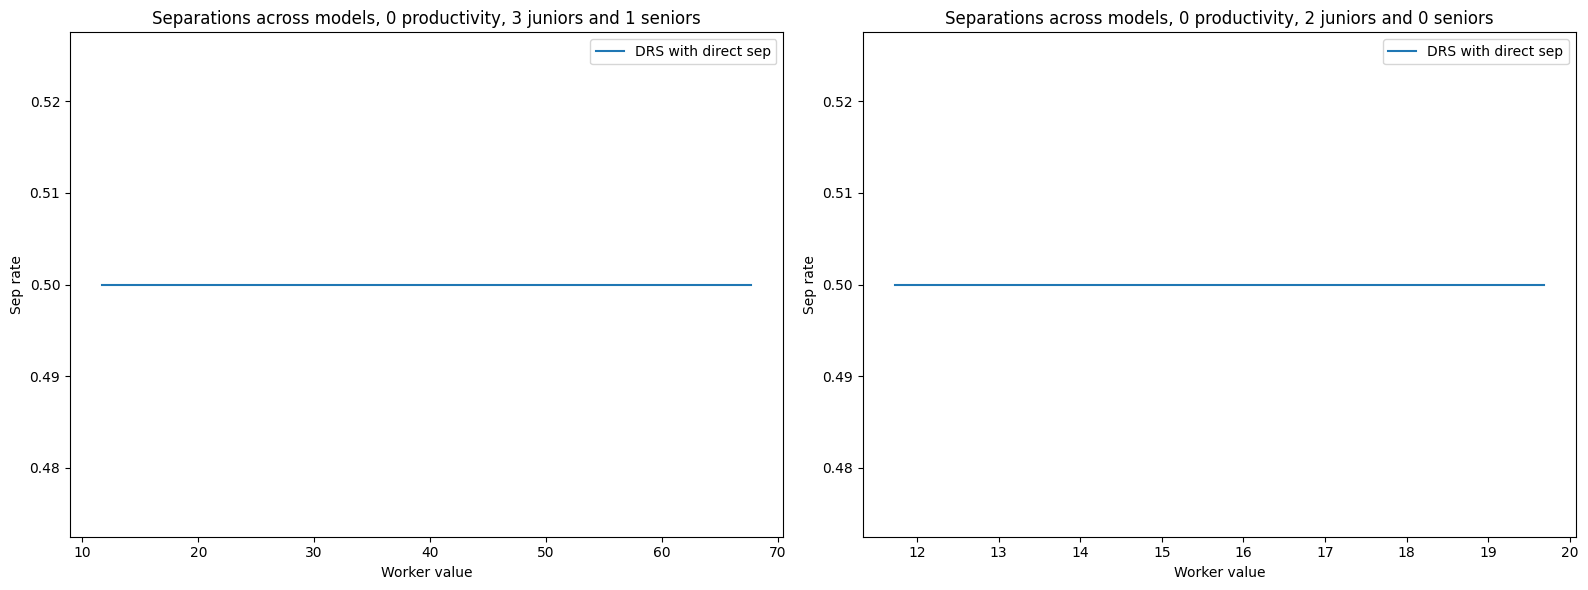

In [17]:
plts.sep(0,p.z_0-1,3,1,2,0,None,None,mwc_hmq_sd_W[...,1,:],mwc_hmq_sd_sep[...,1])

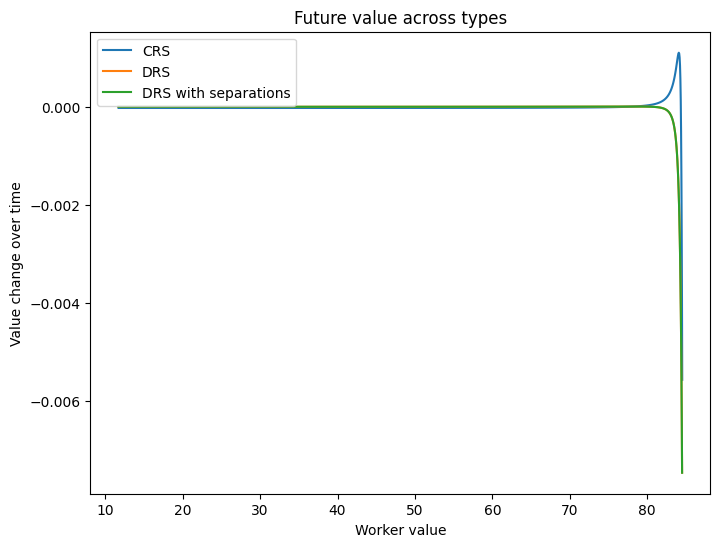

In [19]:
plts.CRSvsDRSpolicy(cc_W,cc_Wstar,mwc_hmq_W[...,0,:],mwc_hmq_Wstar[...,0],mwc_hmq_sd_W[...,0,:],mwc_hmq_sd_Wstar[...,0],mwc_sd_W,mwc_sd_Wstar,0)

In [1]:
plts.ValueComparison(3,1,3,0,cc_W,cc_J,mwc_hmq_W[...,0,:],mwc_hmq_J[...,0],None,None,mwc_hmq_sd_W[...,0,:],mwc_hmq_sd_J[...,0],0)

NameError: name 'plts' is not defined

In [ ]:
plts.ValueComparison(0,2,1,0,cc_W,cc_J,mwch_W,mwch_J,mwch_s_W,mwch_s_J,mwch_sd_W,mwch_sd_J,0)

In [ ]:
plts.ValueComparison(0,2,1,0,cc_W,cc_J,mwc_W,mwc_J,mwch_W,mwch_J,mwc_sd_W,mwc_sd_J,0)

In [ ]:
#Only firings when n1=0? Shit

In [ ]:
            #Interpolating to rho_star and q_star first.
            for iz in range(self.p.num_z):
                for in00 in range(self.p.num_n):
                    for in11 in range(self.p.num_n):
                        J_interpolator = RegularGridInterpolator(( rho_grid, Q_grid), EJpi[iz, in00, in11, ...], bounds_error=False, fill_value=None)
                        W_interpolator = RegularGridInterpolator(( rho_grid, Q_grid), EW1i[iz, in00, in11, ...], bounds_error=False, fill_value=None)
                        Jd0[iz,...,in00,in11] = J_interpolator(( rho_star[iz, ...], q_star[iz, ...]))
                        Wd0[iz,...,in00,in11] = W_interpolator(( rho_star[iz, ...], q_star[iz, ...]))
            #Getting hiring decisions. Very time intestive. Would be nice to have it be faster...somehow
            n0_star[...] = 0

                #start_time = time.time()
            for in00 in range(self.p.num_n):
                Jd_n0[...,in00] = interp_multidim(n1_star,N_grid1,np.moveaxis(Jd0[...,in00,:],-1,0))
                Wd_n0[...,in00] = interp_multidim(n1_star,N_grid1,np.moveaxis(Wd0[...,in00,:],-1,0))

            Jd_n0_0 = interp_multidim(n1_star[...,ax],N_grid1,np.moveaxis(Jd0,-1,0))
            Wd_n0_0 = interp_multidim(n1_star[...,ax],N_grid1,np.moveaxis(Wd0,-1,0)) 
            print("First diff", np.max(np.abs(Jd_n0-Jd_n0_0)))
            if ite_num > 1:
                #elapsed_time = end_time - start_time
                #print(f"Interpolation time: {elapsed_time:.4f} seconds")
                #Ihire = ((Jd0[...,1]-Jd0[...,0]+rho_star*n1_star*(Wd0[...,1]-Wd0[...,0])) > self.p.hire_c) & (N_grid[self.grid[1]]+N_grid1[self.grid[2]] < self.p.n_bar - 1)
                Ihire = ((Jd_n0[...,1]-Jd_n0[...,0]) / (N_grid[1]-N_grid[0]) > self.p.hire_c/self.p.beta) & (N_grid[self.grid[1]]+N_grid1[self.grid[2]] < self.p.n_bar - 1)
                #slice_Jd0 = Jd0[idx[0], idx[1], idx[2], idx[3], 1:] - Jd0[idx[0], idx[1], idx[2], idx[3], :-1]+n1_star[idx[0], idx[1], idx[2], idx[3]]*rho_star[idx[0], idx[1], idx[2], idx[3]]*(Wd0[idx[0], idx[1], idx[2], idx[3],1:]-Wd0[idx[0], idx[1], idx[2], idx[3],:-1])  # Shape should be (5,)
                #print("n0_star borders", n0_star.min(), n0_star.max())    
                n0_star = n0(Jd_n0, n0_star, N_grid, Ihire, self.p.hire_c / self.p.beta)
            
            #Checking whether the two versions give the same results
            
            Jd_check = np.zeros_like(Jd_n0)
            Wd_check = np.zeros_like(Jd_n0)

            for iz in range(self.p.num_z):
             for in00 in range(self.p.num_n):

                J_interpolator = RegularGridInterpolator((N_grid1, rho_grid, Q_grid), EJpi[iz, in00, ...], bounds_error=False, fill_value=None)
                Jd_check[iz, ..., in00] = J_interpolator((n1_star[iz, ...], rho_star[iz, ...], q_star[iz, ...]))
            
            print(np.max(np.abs(Jd_n0-Jd_check)))

            
            #Future optimal expectations
            EJ1_star = interp_multidim(n0_star,N_grid,np.moveaxis(Jd_n0,-1,0))
            EW1_star = interp_multidim(n0_star,N_grid,np.moveaxis(Wd_n0,-1,0))
            

            #Getting the derivative of the future job value wrt n1:
            floorn1=np.floor(np.interp( n1_star, N_grid1, range(self.p.num_n))).astype(int)
            ceiln1=np.ceil(np.interp( n1_star, N_grid1, range(self.p.num_n))).astype(int)   
            #For this, fix the future (arbitrary) senior size, but make sure th ejunior size is correct         
            for in11 in range(self.p.num_n):
                Jd_n1[...,in11] = interp_multidim(n0_star,N_grid,np.moveaxis(Jd0[...,in11],-1,0))
                Wd_n1[...,in11] = interp_multidim(n0_star,N_grid,np.moveaxis(Wd0[...,in11],-1,0))
            EJderiv0,EWderiv = anotherEJderivative(Jd_n1,Wd_n1,ceiln1,floorn1,n0_star,rho_star,q_star,EJpi,EW1i,N_grid,rho_grid,Q_grid,self.p.num_z,self.p.num_n,self.p.n_bar,self.p.num_v,self.p.num_q)
            EJderiv = EJderiv0+n1_star*rho_star*EWderiv

In [ ]:
import matplotlib.pyplot as plt
import os
# Create a directory to save plots
output_dir = 'Plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
jun=0
sen=0

if mwch_W is not None:        
    plt.plot(mwch_W[p.z_0-1, jun, sen, :, 1], mwch_n0[p.z_0-1, jun, sen, :], label='DRS')
if mwch_s_W is not None:        
    plt.plot(mwch_s_W[p.z_0-1, jun, sen, :, 1], mwch_s_n0[p.z_0-1, jun, sen, :], label='DRS with inv sep')
if mwch_sd_W is not None:        
    plt.plot(mwch_sd_W[p.z_0-1, jun, sen, :, 1], mwch_sd_n0[p.z_0-1, jun, sen, :], label='DRS with direct sep')

plt.title(f'Hires across models, {jun} juniors and {sen} seniors')
plt.xlabel('Worker value')
plt.ylabel('Hires')
plt.legend()
#Why does the job value rise when separations go to 1?
#Alex: when something strange is arising at the edge of the grid, it might be the extrapolation issue.
#Is there a way to check my intuition? Seems consistent with size and productivity changes

In [ ]:
plts.CRSvsDRSdirect(cc_J,mwc_J,0)

In [ ]:
plts.CRSvsDRSsurplus(cc_J,cc_W,mwc_J,mwc_W,0)

In [ ]:
import matplotlib.pyplot as plt
import os
# Create a directory to save plots
output_dir = 'Plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
np.abs(mwc_s_sep[:,:1,:3,:]-mwc_sd_sep[:,:1,:3,:]).max()

In [ ]:
np.max(np.abs(mwc_s_sep[:,3,0,:]-mwc_sd_sep[:,3,0,:]))

In [ ]:
np.max(mwc_sd_sep[:,1,1,:])

In [ ]:
mwc_sd_sep[:,1,1,:]

In [ ]:
mwc_s_J[:,1,0,:]/mwc_s_J[:,3,0,:] #this is odd, should be 1/3 exactly, no? it is 1/3 in the case without separations, so why not here? there aren't even any separations!

In [ ]:
np.max(mwc_s_sep[:,3,0,:])

In [ ]:
            #something like: sep_star = interp(0,foc_sep,sep_grid) + extra conditions
            #need derivatives of future expectations!
            # for that, I interpolate onto rho_star,n0_star, and one of n1_s/q_s. If I'm looking for derivative wrt size, I interpolate onto q_s and THEN take the difference between two discrete values
            #n1_s[iz,in0,in1,iv,iq,s] = (N_grid[in0]*(1-sep_grid[s])+N_grid1[in1]) * pc_temp[iz,in0,in1,iv] #Gives me sep for every damn value hell yeah
            #n1_s_ceil = np.ceil(np.interp( n1_s, N_grid1, range(self.p.num_n))).astype(int)
            #n1_s_floor = np.floor(np.interp( n1_s, N_grid1, range(self.p.num_n))).astype(int)
            #J_n1[iz,...,s,in11] = RegularGridInterpolator((N_grid, rho_grid, Q_grid), EJpi[iz, :, in11, ...], bounds_error=False, fill_value=None) ((n0_star[iz, ...], rho_star[iz, ...], q_s[iz, ...,s]))
            #J_fut_deriv_n[...,s] = (J_n1[...,s,n1_s_ceil[...,s]] - J_n1[...,s,n1_s_floor[...,s]] ) / (N_grid1[n1_s_ceil[...,s]] - N_grid1[n1_s_floor[...,s]]) #This may need a proper loop
            # Boundary check: first_bound = (n1_s_ceil==0), last_bound = (N_grid1[n1_s_floor]==n_bar)
            #J_fut_deriv_n[first_bound] = (J_n1[first_bound,1] - J_n1[first_bound,0] ) / (N_grid1[1] - N_grid1[0])
            #J_fut_deriv_n[last_bound] = (J_n1[last_bound,-1] - J_n1[last_bound,-2] ) / (N_grid1[-1] - N_grid1[-2])
 
            #q_s = (N_grid[self.grid[1]] * (self.p.q_0 - np.max(sep_grid[s]-( 1- self.p.q_0),0))+Q_grid[self.grid[4]]*N_grid1[self.grid[2]]) / (N_grid[self.grid[1]]*(1-sep_grid[s])+N_grid1[self.grid[2]])
            #J_q[iz,...,s,iqq] = RegularGridInterpolator((N_grid, N_grid1, rho_grid), EJpi[iz, ..., iqq], bounds_error=False, fill_value=None) ((n0_star[iz, ...], n1_s[iz,...,s], rho_star[iz, ...]))
            #J_fut_deriv_q[...,s] = (J_q[...,s,q_s_ceil[...,s]] - J_n1  [...,s,q_s_floor[...,s]] ) / (Q_grid[q_s_ceil[...,s]] - Q_grid[q_s_floor[...,s]]) #This may need a proper loop
            # Boundary check: first_bound = (q_s_ceil==0), last_bound = (Q_grid[q_s_floor]=1.0)
            #J_fut_deriv_q[first_bound] = (J_q[first_bound,1] - J_q[first_bound,0] ) / (Q_grid1[1] - Q_grid1[0])
            #J_fut_deriv_q[last_bound] = (J_q[last_bound,-1] - J_q[last_bound,-2] ) / (Q_grid1[-1] - Q_grid1[-2])
            #q_deriv_s = N_grid[grid[1]] * q_s / (N_grid1[grid[2]]+(1-sep_grid[s])*N_grid[grid[1]]) #Probably need to loop over s. Not efficient, but simpler than redoing the whole self.grid thing
            #worker_fut_value = interp ( rho_star,rho_grid,re+EW1i)                    #This is because we don't yet have the worker future value yet. OR just use EW1_star and re_star??? a little risky but possible.
            #Could be a good start
            #foc_sep[...,s] = - J_fut_deriv[...,s] * pc_temp + J_fut_deriv_q * q_deriv_s - (re+EW1i - EUi) / self.pref.inv_utility_1d(self.v_0-self.p.beta*(s_grid[s] * EUi + (1-s_grid[s]) * (EW1_star + re_star)
            # sep_neg = np.all (foc <= 0, axis = -1)
            # sep_max = np.all (foc > 0, axis = -1)
            # sep_star[sep_neg] = 0
            # sep_star[sep_max] = 1.0 #OH SHIT WHAT IF THE Q IS ALREADY AT ITS MAX? I think this should account for it, no?
            #sep_star = interp_multidim(0,-impose_decreasing(foc_sep),sep_grid) 